In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt
import random
import re

from sklearn import model_selection

/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from stop_words import get_stop_words

In [3]:
ROOT_PATH='/home/asr/prj_SlotTagger/dnn_train'

## Six Ambiguity Problem: VERB or NUM?

In [4]:
%%time


num_lines_num  = sum(1 for line in open(ROOT_PATH + '/amb_raw/sei_6/num/sei_num'))
num_lines_ver  = sum(1 for line in open(ROOT_PATH + '/amb_raw/sei_6/ver/sei_verb'))

ratio = num_lines_num  / float(num_lines_ver) 
print('Corpus_six_num: %d, Corpus_six_ver: %d, Ratio: %0.3f' %(num_lines_num, num_lines_ver, ratio)) 

Corpus_six_num: 105181, Corpus_six_ver: 285704, Ratio: 0.368
CPU times: user 98.5 ms, sys: 4.64 ms, total: 103 ms
Wall time: 101 ms


## Building the Data-Frame (Balanced)

In [5]:
def load_dataset(directory_1, directory_2):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(0)

    return pd.DataFrame.from_dict(data)




In [6]:
%%time
directory_1 = ROOT_PATH + '/amb_raw/sei_6/num/'
directory_2 = ROOT_PATH + '/amb_raw/sei_6/ver/'

dataset_df = load_dataset(directory_1, directory_2)

CPU times: user 1.15 s, sys: 38.9 ms, total: 1.19 s
Wall time: 1.19 s


In [7]:
# Check Balanced
dataset_df.groupby('class').count()

,sentence
class,
0,104815
1,105181


In [8]:
# Print some samples
for i in range(10):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

a al comma dopo le parole inferiore a sei
whoa whoa whoa sei cifre
a anni accoltellò all'addome jimmy davis un bambino di sei anni e lo nascose nei
warner bros ha comprato il mio libro per sei cifre
a anni da del mondo e con l'uscita al primo turno da sei slam
vuoi tirare avanti con una somma di appena sei cifre per così tanto
a anni e sei mesi dalla
tre lettere sei cifre
a anni passa nelle giovanili del milan dove trascorre sei stagioni laureandosi per due volte
sei denunce per furto d auto in due delle quali si dichiara
a a sei
sei cifre per cominciare
a a sei minuti dal
sei cifre non mi serviva altro
aa vv sei secoli di musica nel duomo
sei cifre facili
a balaustra e sei gruppi di scalini che su ambedue i lati conducono verso la città
sei cifre ecco qua
a baltimora nel maryland il più giovane di sei figli
sei cifre come il codice a barre che potrebbe essere l algoritmo magico


In [9]:
dataset_df.head(5)

,sentence,class
0,a al comma dopo le parole inferiore a sei,1
1,a anni accoltellò all'addome jimmy davis un ba...,1
2,a anni da del mondo e con l'uscita al primo tu...,1
3,a anni e sei mesi dalla,1
4,a anni passa nelle giovanili del milan dove tr...,1


In [10]:
dataset_df.tail(5)

,sentence,class
209991,sei denunce per furto d auto in due delle qual...,0
209992,tre lettere sei cifre,0
209993,vuoi tirare avanti con una somma di appena sei...,0
209994,warner bros ha comprato il mio libro per sei c...,0
209995,whoa whoa whoa sei cifre,0


### Statistics about the dataset

In [11]:
# Counting number of words and mean
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

sentence    8.523429
class       1.000000
dtype: float64

In [12]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

sentence    286
class         1
dtype: int64

In [13]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

sentence    4.187989
class       0.000000
dtype: float64

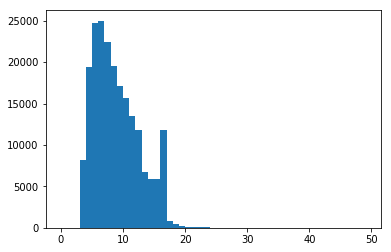

In [14]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Shuffle the Dataset

In [15]:

index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset = dataset_df.set_index([index]).sort_index()

dataset.head(10)

,sentence,class
0,sia in patria da sei anni,1
1,mononucleosi tornò ad allenarsi dopo due mesi ...,1
2,tu sei stato dichiarato non colpevole per infe...,0
3,sposato con un figlio di sei anni,1
4,okay niente gite per almeno sei mesi,1
5,per provare che sei più forte di lui,0
6,che eravamo insieme alle sei del mattino il qu...,1
7,voglio aggiungere attività a un calendario per...,1
8,tu vieni con noi sei ancora in punizione,0
9,il modo in cui sei riuscito a girarla,0


In [16]:
exclude1 = ['\t', '"', '?'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
    return text.lower().strip()

sentence_processed = list(map(lambda text: clean_text(text), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(20)

,sentence,class
0,sia in patria da sei anni,1
1,mononucleosi tornò ad allenarsi dopo due mesi ...,1
2,tu sei stato dichiarato non colpevole per infe...,0
3,sposato con un figlio di sei anni,1
4,okay niente gite per almeno sei mesi,1
5,per provare che sei più forte di lui,0
6,che eravamo insieme alle sei del mattino il qu...,1
7,voglio aggiungere attività a un calendario per...,1
8,tu vieni con noi sei ancora in punizione,0
9,il modo in cui sei riuscito a girarla,0


In [32]:
for i in range(10):
    print(dataset.iloc[i]['sentence'])
    print(dataset.iloc[-i -1]['sentence'])

quando ti sei dato al fumo
sei un duro amico
sei ore in ufficio vorrei vedere te
prima settimana di guerra e te ne sei già beccata una nella gamba
ricorda che siamo sei ore avanti
sei un ingegnere lo sai
sei venuto a trovare montecristo
mi restavano sei mesi
ti sei lamentato che non ero d aiuto e questo sta per cambiare
sei venuto ad ammirare la tua opera
non sono stata senza sesso per due settimana da quando sono stata in coma per sei
terza in un girone a sei squadre
tu sei divenuta un essere superiore
coniugi ebbero altri sei figli
visto che sei un auto rotta prima o poi ti fermerai giusto
sembra che tu voglia dire qualcosa ma ti sei preso una bella mazzata
pur essendo in forze di uno a sei nadir shah riscì a schiacciare l esercito mughal in
vuol dire che sei ancora nella zona
com è che sei stata tanto sciocca da venire qua sotto
già l omicidio è avvenuto sei settimane fa


### Split for Semi-Supervised Dataset Learning (Train, Valid & Infer Sets)

In [55]:
splitter = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
main_index = splits[0][0]
test_index = splits[0][1]

main_df = dataset.loc[main_index,:]
print('Training-Set size: %d' %len(main_df))

test_df = dataset.loc[test_index,:]
print('Test-Set size: %d' %len(test_df))

Training-Set size: 157764
Test-Set size: 52589


In [56]:
main_df = main_df.dropna()
len(main_df.dropna())

157764

In [57]:
test_df = test_df.dropna()
len(test_df.dropna())

52589

In [71]:
splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.97, random_state=19850610)

splits = list(splitter.split(X=main_df['sentence'], y=main_df['class']))
train_index = splits[0][0]
infer_index = splits[0][1]

train_df = main_df.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

infer_df = main_df.loc[infer_index,:]
print('Inference-Set size: %d' %len(infer_df))

Training-Set size: 4732
Inference-Set size: 153032


/home/asr/tensorflow-cpu/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [72]:
train_df = train_df.dropna()
len(train_df)

3574

In [73]:
infer_df = infer_df.dropna()
len(infer_df)

114793

In [74]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Test Set")
validation_value_counts = test_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(test_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(test_df)*100,2)))
print("")
print("Inference Set")
inference_value_counts = infer_df['class'].value_counts()
print(inference_value_counts)
print("class 0 %: {}".format(round(inference_value_counts[0]/len(infer_df)*100,2)))
print("class 1 %: {}".format(round(inference_value_counts[1]/len(infer_df)*100,2)))

Training Set
1.0    1792
0.0    1782
Name: class, dtype: int64
class 0 %: 49.86
class 1 %: 50.14

Test Set
1    26296
0    26293
Name: class, dtype: int64
class 0 %: 50.0
class 1 %: 50.0

Inference Set
1.0    57604
0.0    57189
Name: class, dtype: int64
class 0 %: 49.82
class 1 %: 50.18


In [75]:
train_df['class'] = train_df['class'].apply(lambda x: str(int(x)))
test_df['class'] = test_df['class'].apply(lambda x: str(int(x)))
infer_df['class'] = infer_df['class'].apply(lambda x: str(int(x)))

In [77]:
train_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/train_sei_sslear.tsv', header=False, index=False, sep='\t')
test_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/test_sei_sslear.tsv', header=False, index=False, sep='\t')
infer_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/infer_sei_sslear.tsv', header=False, index=False, sep='\t')

### Split for Tagger Classifier (Train, Valid)

In [17]:

splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 178496
Validation-Set size: 31500


In [18]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
1    89404
0    89092
Name: class, dtype: int64
class 0 %: 49.91
class 1 %: 50.09

Validation Set
1    15777
0    15723
Name: class, dtype: int64
class 0 %: 49.91
class 1 %: 50.09


In [19]:

train_df.to_csv(os.path.join(ROOT_PATH, 'datasets/sei_6/train_data_v2.tsv'), header=False, index=False, sep='\t')
valid_df.to_csv(os.path.join(ROOT_PATH, 'datasets/sei_6/valid_data_v2.tsv'), header=False, index=False, sep='\t')

## Calculate Vocabulary and Save it

In [20]:
stop_words = get_stop_words('italian') + get_stop_words('english')

#my_stop_words = ['puoi','posso','vediamo','guarda','vorrei','voglio','dici','fammi']
my_stop_words = []
for my_word in my_stop_words:
    stop_words.append(my_word)
    
# Important step for this dataset!!!!
stop_words.remove('sei')

In [21]:
stop_words

['a',
 'abbia',
 'abbiamo',
 'abbiano',
 'abbiate',
 'ad',
 'adesso',
 'agl',
 'agli',
 'ai',
 'al',
 'all',
 'alla',
 'alle',
 'allo',
 'allora',
 'altre',
 'altri',
 'altro',
 'anche',
 'ancora',
 'avemmo',
 'avendo',
 'avere',
 'avesse',
 'avessero',
 'avessi',
 'avessimo',
 'aveste',
 'avesti',
 'avete',
 'aveva',
 'avevamo',
 'avevano',
 'avevate',
 'avevi',
 'avevo',
 'avrai',
 'avranno',
 'avrebbe',
 'avrebbero',
 'avrei',
 'avremmo',
 'avremo',
 'avreste',
 'avresti',
 'avrete',
 'avrà',
 'avrò',
 'avuta',
 'avute',
 'avuti',
 'avuto',
 'c',
 'che',
 'chi',
 'ci',
 'coi',
 'col',
 'come',
 'con',
 'contro',
 'cui',
 'da',
 'dagl',
 'dagli',
 'dai',
 'dal',
 'dall',
 'dalla',
 'dalle',
 'dallo',
 'degl',
 'degli',
 'dei',
 'del',
 'dell',
 'della',
 'delle',
 'dello',
 'dentro',
 'di',
 'dov',
 'dove',
 'e',
 'ebbe',
 'ebbero',
 'ebbi',
 'ecco',
 'ed',
 'era',
 'erano',
 'eravamo',
 'eravate',
 'eri',
 'ero',
 'essendo',
 'faccia',
 'facciamo',
 'facciano',
 'facciate',
 'faccio

In [22]:
'ci' in stop_words

True

In [82]:
ww = ['criks', 'crjis3','cr456is', '45crist','1v','f4','16','l','9','5ffff56566778','cv', 'ai']

falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

[w for w in ww if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]

['criks', '16', '9', 'cv', 'ai']

In [27]:

# This function returns FALSE if there is a digit in the string (i.e '4mmm', 'm44m', 'llp4')
#falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

def get_vocab():
    #allWords = []
    vocab = set()
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #words_ = words_only
        #allWords = allWords + words_
        word_set = set(words_)
        vocab.update(word_set)
    
    #vocab.remove('')
    return list(vocab)#, allWords

def get_all_words():
    allWords = []
    cnt = 0
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 1 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #words_ = words_only
        allWords = allWords + words_
        #word_set = set(words_)
        cnt += 1
        if cnt%10000==0:
            print('-----------', cnt)
    
    return allWords



In [28]:
%%time
vocab = get_vocab()
print('--------------------', len(vocab))


-------------------- 64006
CPU times: user 820 ms, sys: 2 µs, total: 820 ms
Wall time: 820 ms


In [29]:
'ci' in vocab

True

In [30]:
%%time
allWords = get_all_words()
print('--------------------', len(allWords))

----------- 10000
----------- 20000
----------- 30000
----------- 40000
----------- 50000
----------- 60000
----------- 70000
----------- 80000
----------- 90000
----------- 100000
----------- 110000
----------- 120000
----------- 130000
----------- 140000
----------- 150000
----------- 160000
----------- 170000
-------------------- 1522514
CPU times: user 44min 42s, sys: 596 ms, total: 44min 43s
Wall time: 44min 44s


In [31]:
from collections import Counter
cnt_allWords = Counter(allWords)

In [32]:
vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

In [33]:
vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)


In [34]:
'ci' in vocab_words_sorted_by_appearence_list

True

In [54]:
STOP_WORDS = False
REDUCED_SIZE_VOC = True
SIZE_VOC = 25000

vocab = vocab_words_sorted_by_appearence_list

if STOP_WORDS:
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

print(len(vocab))
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
print(len(vocab))


64006
25000


In [132]:
'ci' in vocab

True

In [133]:
'abbiamo' in vocab

True

In [152]:
vocab[-20:]

['roll',
 'mantiene',
 'addison',
 'pugnalato',
 'consta',
 'vivevo',
 'restringe',
 'dilettanti',
 'caramelle',
 'primitivo',
 'discarica',
 'urla',
 'dormiva',
 'bè',
 'maialino',
 'accorgano',
 'idrogeno',
 'sostituiti',
 'travestita',
 'lavoravano']

### Building a Mixed Vocabulary
###### half of most frequent words, half of random selection among all the words (uniform distribution)

In [69]:
# From 0 to boundary_point: words selected by their frequency (the most frequent words)
# From boundary_point to len(voc): words random selected
boundary_point = 19000

def random_selection_from_vocab(vocabulary, start):
    length_voc = len(vocabulary)
    vocab = np.array(vocabulary)
    indxs = np.random.choice(range(start, length_voc), length_voc - start, replace=False)
    return list(vocab[indxs])

vocab = vocab[0:boundary_point] + random_selection_from_vocab(vocab, boundary_point)
vocab[0:10]

['settimana',
 'attività',
 'favore',
 'piacere',
 'appuntamento',
 'calendario',
 'prossimo',
 'evento',
 'condividere',
 'nome']

In [30]:
#words_and_frequence

In [134]:
# Check if a word is in VOC or STOP_WORDS
ww = 'sei'
print('-----------------', ww in stop_words)
print('-----------------', ww in vocab)

----------------- False
----------------- True


In [55]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(ROOT_PATH, 'datasets/sei_6/vocab_25k_swin_v2.tsv')
with open(PATH_VOC , 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/vocab_list.tsv', 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))
        
PATH_WORDS = os.path.join(ROOT_PATH, 'datasets/sei_6/n_words_25k_swin_v2.tsv')        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(len(vocab)))



In [109]:
# sw = True ---- > swout
# sw = False ---- > swin